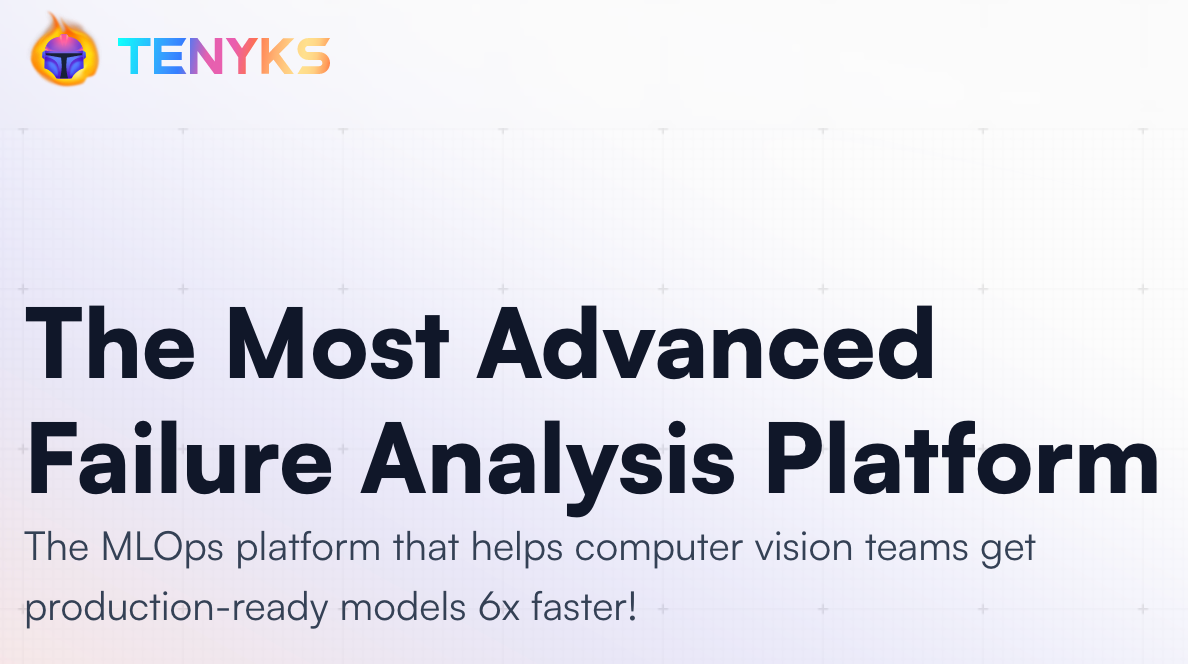

# How to build an Image-to-Image search tool using CLIP & Pinecone

## 1. Python libraries for search

In [ ]:
!pip install requests bs4 google-search-results -qqq

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import requests, lxml, re, json, urllib.request
from bs4 import BeautifulSoup

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36"
}

params = {
    "q": "lord of the rings film scenes", # search query
    "tbm": "isch",                # image results
    "hl": "en",                   # language of the search
    "gl": "us",                   # country where search comes from
    "ijn": "0"                    # page number
}

html = requests.get("https://www.google.com/search", params=params, headers=headers, timeout=30)
soup = BeautifulSoup(html.text, "lxml")

def get_images_with_request_headers():
    del params["ijn"]
    params["content-type"] = "image/png" # parameter that indicate the original media type

    return [img["src"] for img in soup.select("img")]

def get_suggested_search_data():
    suggested_searches = []

    all_script_tags = soup.select("script")

    # https://regex101.com/r/48UZhY/6
    matched_images = "".join(re.findall(r"AF_initDataCallback\(({key: 'ds:1'.*?)\);</script>", str(all_script_tags)))

    # https://kodlogs.com/34776/json-decoder-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes
    # if you try to json.loads() without json.dumps it will throw an error:
    # "Expecting property name enclosed in double quotes"
    matched_images_data_fix = json.dumps(matched_images)
    matched_images_data_json = json.loads(matched_images_data_fix)

    # search for only suggested search thumbnails related
    # https://regex101.com/r/ITluak/2
    suggested_search_thumbnails = ",".join(re.findall(r'{key(.*?)\[null,\"Size\"', matched_images_data_json))

    # https://regex101.com/r/MyNLUk/1
    suggested_search_thumbnail_encoded = re.findall(r'\"(https:\/\/encrypted.*?)\"', suggested_search_thumbnails)

    for suggested_search, suggested_search_fixed_thumbnail in zip(soup.select(".PKhmud.sc-it.tzVsfd"), suggested_search_thumbnail_encoded):
        suggested_searches.append({
            "name": suggested_search.select_one(".VlHyHc").text,
            "link": f"https://www.google.com{suggested_search.a['href']}",
            # https://regex101.com/r/y51ZoC/1
            "chips": "".join(re.findall(r"&chips=(.*?)&", suggested_search.a["href"])),
            # https://stackoverflow.com/a/4004439/15164646 comment by Frédéric Hamidi
            "thumbnail": bytes(suggested_search_fixed_thumbnail, "ascii").decode("unicode-escape")
        })

    return suggested_searches

def get_original_images():

    """
    https://kodlogs.com/34776/json-decoder-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes
    if you try to json.loads() without json.dumps() it will throw an error:
    "Expecting property name enclosed in double quotes"
    """

    google_images = []

    all_script_tags = soup.select("script")

    # # https://regex101.com/r/48UZhY/4
    matched_images_data = "".join(re.findall(r"AF_initDataCallback\(([^<]+)\);", str(all_script_tags)))

    matched_images_data_fix = json.dumps(matched_images_data)
    matched_images_data_json = json.loads(matched_images_data_fix)

    # https://regex101.com/r/VPz7f2/1
    matched_google_image_data = re.findall(r'\"b-GRID_STATE0\"(.*)sideChannel:\s?{}}', matched_images_data_json)

    # https://regex101.com/r/NnRg27/1
    matched_google_images_thumbnails = ", ".join(
        re.findall(r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]',
                   str(matched_google_image_data))).split(", ")

    thumbnails = [
        bytes(bytes(thumbnail, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for thumbnail in matched_google_images_thumbnails
    ]

    # removing previously matched thumbnails for easier full resolution image matches.
    removed_matched_google_images_thumbnails = re.sub(
        r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]', "", str(matched_google_image_data))

    # https://regex101.com/r/fXjfb1/4
    # https://stackoverflow.com/a/19821774/15164646
    matched_google_full_resolution_images = re.findall(r"(?:'|,),\[\"(https:|http.*?)\",\d+,\d+\]", removed_matched_google_images_thumbnails)

    full_res_images = [
        bytes(bytes(img, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for img in matched_google_full_resolution_images
    ]

    return full_res_images

Running the programmatic search script

In [ ]:
list_image_urls = get_original_images()

## 2. Python libraries for Pinecone

In [ ]:
!pip3 -qqq install transformers torch datasets

# The following two libraries avoid the UnidentifiedImageError
!pip3 -qqq install gdcm
!pip3 -qqq install pydicom
!pip -qqq install faiss-gpu
!pip -qqq install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 487.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

## 3. Python libraries for CLIP

In [ ]:
import os
import faiss
import torch
import skimage
import requests
import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Get the dataset
image_data = load_dataset("conceptual_captions", split="train")

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

Testing and validating the images we downloaded

In [ ]:
def get_image(image_URL):
   response = requests.get(image_URL)
   image = Image.open(BytesIO(response.content)).convert("RGB")
   return image

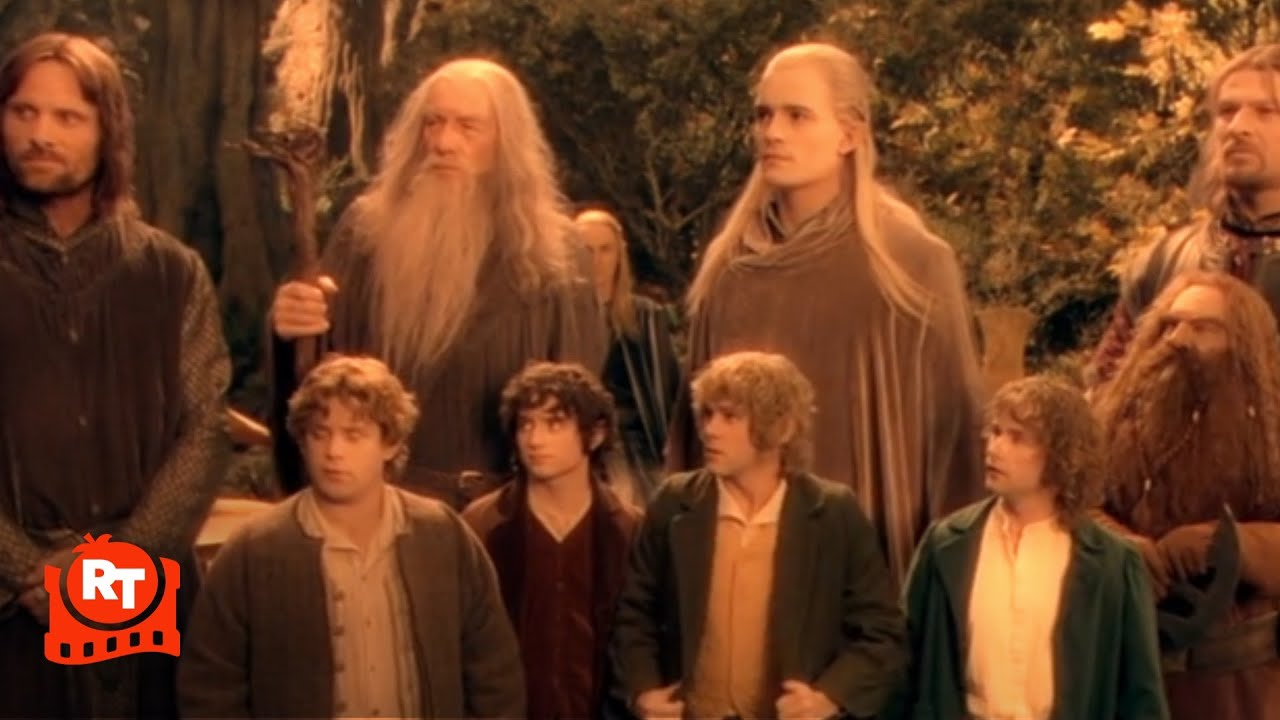

In [ ]:
one_image = get_image(list_image_urls[0])
one_image

## 4. Accessing CLIP

In [ ]:
def get_model_info(model_ID, device):
	# Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
	# Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
  # Return model, processor & tokenizer
	return model, processor, tokenizer

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [ ]:
model, processor, tokenizer

## 5. Divide and Conquer: Functions to obtain one embedding and many embeddings

In [ ]:
def get_single_image_embedding(my_image,processor, model, device):
  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
      )["pixel_values"].to(device)
  embedding = model.get_image_features(image)
  # convert the embeddings to numpy array
  return embedding.cpu().detach().numpy()

In [ ]:
one_vector = get_single_image_embedding(one_image, processor, model, device) # Simple test

In [ ]:
def check_valid_URL(image_URL):
    try:
        response = requests.get(image_URL)
        if response.status_code != 200:
            return False
        Image.open(BytesIO(response.content))
        return True
    except Exception:
        return False

In [ ]:
def get_all_image_embeddings_from_urls(dataset, processor, model, device, num_images=100):
    embeddings = []

    # Limit the number of images to process
    dataset = dataset[:num_images]
    working_urls = []

    #for image_url in dataset['image_url']:
    for image_url in dataset:
      if check_valid_URL(image_url):
          try:
              # Download the image
              response = requests.get(image_url)
              image = Image.open(BytesIO(response.content)).convert("RGB")
              # Get the embedding for the image
              embedding = get_single_image_embedding(image, processor, model, device)
              #embedding = get_single_image_embedding(image)
              embeddings.append(embedding)
              working_urls.append(image_url)
          except Exception as e:
              print(f"Error processing image from {image_url}: {e}")
      else:
          print(f"Invalid or inaccessible image URL: {image_url}")

    return embeddings, working_urls

In [ ]:
LOR_embeddings, list_valid_image_urls = get_all_image_embeddings_from_urls(list_image_urls, processor, model, device, num_images=100)

Invalid or inaccessible image URL: https://blog.frame.io/wp-content/uploads/2021/12/lotr-forced-perspective-cart-bilbo-gandalf.jpg
Invalid or inaccessible image URL: https://www.cineworld.co.uk/static/dam/jcr:9389da12-c1ea-4ef6-9861-d55723e4270e/Screenshot%202020-08-07%20at%2008.48.49.png
Invalid or inaccessible image URL: https://upload.wikimedia.org/wikipedia/en/3/30/Ringwraithpic.JPG


In [ ]:
assert len(LOR_embeddings) == len(list_valid_image_urls)

## 6. Vector DBs baby! Ingesting data in Pinecone!

In [ ]:
pinecone.init(
   api_key = "YOUR Pinecone API KEY",
   environment="gcp-starter"  # find next to API key in console
)

my_index_name = "image-to-image"
vector_dim = all_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  print("Index not present")

my_index = pinecone.Index(index_name = my_index_name)

In [ ]:
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 5e-05,
 'namespaces': {'': {'vector_count': 5}},
 'total_vector_count': 5}

In [ ]:
image_data_df["vector_id"] = image_data_df.index
image_data_df["vector_id"] = image_data_df["vector_id"].apply(str)

# Get all the metadata
final_metadata = []
for index in range(len(image_data_df)):
 final_metadata.append({
     'ID':  index,
     'caption': image_data_df.iloc[index].caption,
     'image': image_data_df.iloc[index].image_url
 })

image_IDs = image_data_df.vector_id.tolist()
image_embeddings = [arr.tolist() for arr in image_data_df.img_embeddings.tolist()]

# Create the single list of dictionary format to insert
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))
# Upload the final data
my_index.upsert(vectors = data_to_upsert)
# Check index size for each namespace
my_index.describe_index_stats()

In [ ]:
def create_data_to_upsert_from_urls(dataset,  embeddings, num_images):
  metadata = []
  image_IDs = []
  for index in range(len(dataset)):
    metadata.append({
        'ID': index,
        'image': dataset[index]#['image_url']
    })
    image_IDs.append(str(index))
  image_embeddings = [arr.tolist() for arr in embeddings]
  data_to_upsert = list(zip(image_IDs, image_embeddings, metadata))
  return data_to_upsert

In [ ]:
LOR_data_to_upsert = create_data_to_upsert_from_urls(list_valid_image_urls, LOR_embeddings, len(list_valid_image_urls))

In [ ]:
my_index.upsert(vectors = LOR_data_to_upsert)

{'upserted_count': 97}

In [ ]:
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.00097,
 'namespaces': {'': {'vector_count': 97}},
 'total_vector_count': 97}

## 7. LOR results

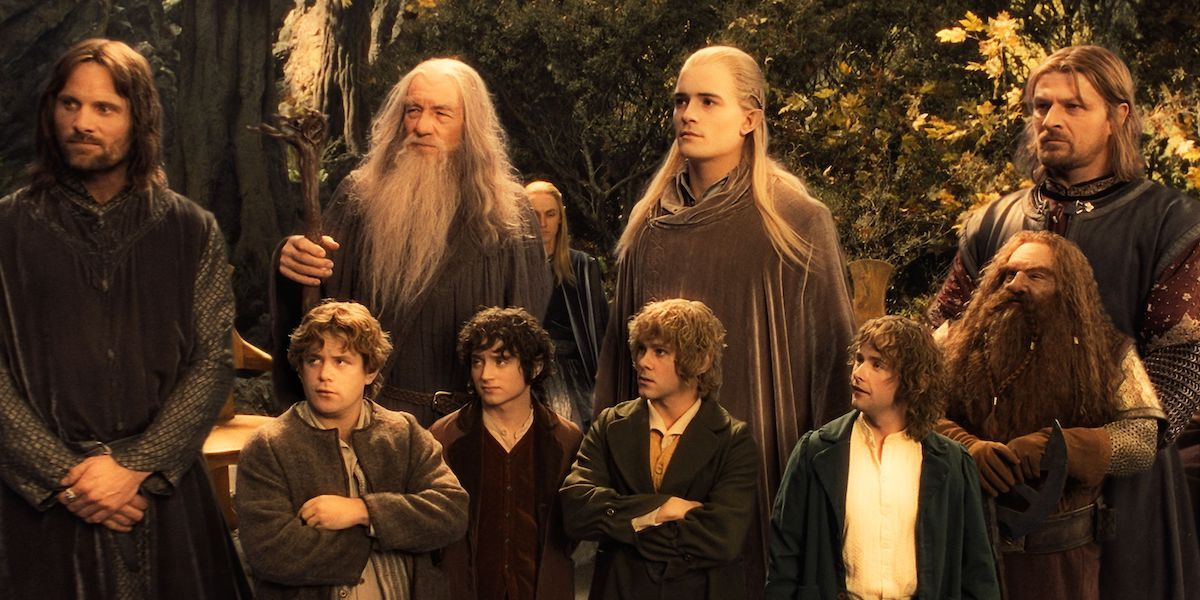

In [ ]:
LOR_image_query = get_image(list_valid_image_urls[4])
LOR_image_query

In [ ]:
LOR_query_embedding = get_single_image_embedding(LOR_image_query, processor, model, device).tolist()
LOR_results = my_index.query(LOR_query_embedding, top_k=3, include_metadata=True)

## 8. Plot results

In [ ]:
def extract_highest_score(match_data):
  # Ensure there are matches in the input data
  if 'matches' in match_data and isinstance(match_data['matches'], list) and len(match_data['matches']) > 0:
      # Find the match with the highest score
      highest_score_match = max(match_data['matches'], key=lambda x: x['score'])

      # Extract the required keys for the highest score
      result = {
          'id': highest_score_match['id'],
          'score': highest_score_match['score'],
          'image_url': highest_score_match['metadata']['image']
      }
      return result
  else:
      return None

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
import requests

In [ ]:
def plot_top_matches_seaborn(match_data):
    if 'matches' in match_data and isinstance(match_data['matches'], list) and len(match_data['matches']) > 0:
        # Sort the matches by score in descending order and take the top 3
        sorted_matches = sorted(match_data['matches'], key=lambda x: x['score'], reverse=True)[:3]

        # Create a grid for displaying the top 3 matches
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        for i, match in enumerate(sorted_matches):
            ax = axs[i]
            image_url = match['metadata']['image']
            id_val = match['id']
            score_val = match['score']

            # Load and display the image using Seaborn
            #response = requests.get(image_url)
            #img = Image.open(BytesIO(response.content))
            img = np.array(PIL.Image.open(urllib.request.urlopen(image_url)))
            #sns.heatmap([[0]], ax=ax, cbar=False, xticklabels=False, yticklabels=False)
            img = PIL.Image.fromarray(img).resize((300, 300))
            #img = img.resize((300, 300))
            ax.imshow(img)
            ax.set_title(f"ID: {id_val}\nScore: {score_val:.2f}")
            ax.axis('off')

        plt.show()
    else:
        print("No 'matches' found in the input data or the list is empty.")



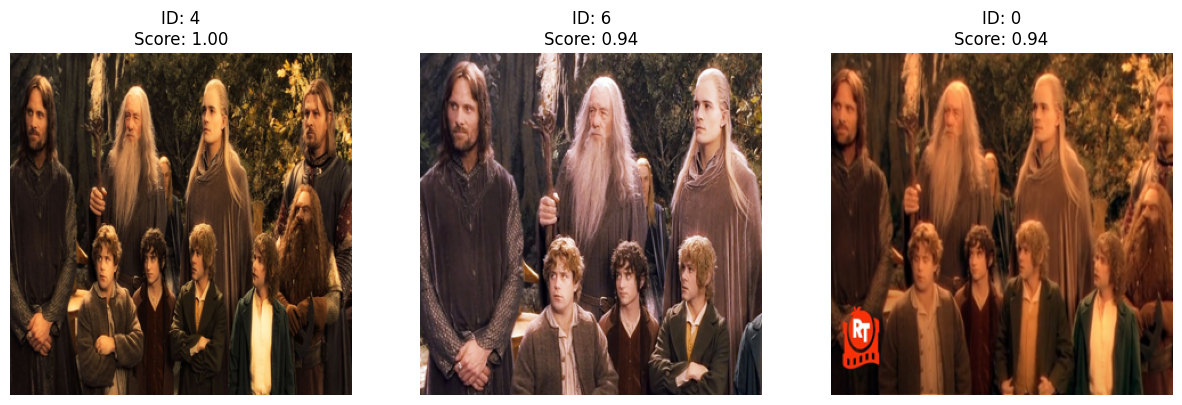

In [ ]:
plot_top_matches_seaborn(LOR_results)

Or simpler ...

In [ ]:
import random

Sample image with index 47 in https://www.intofilm.org/intofilm-production/scaledcropped/870x489https%3A/s3-eu-west-1.amazonaws.com/images.cdn.filmclub.org/film__3930-the-lord-of-the-rings-the-fellowship-of-the-ring--hi_res-a207bd11.jpg/film__3930-the-lord-of-the-rings-the-fellowship-of-the-ring--hi_res-a207bd11.jpg


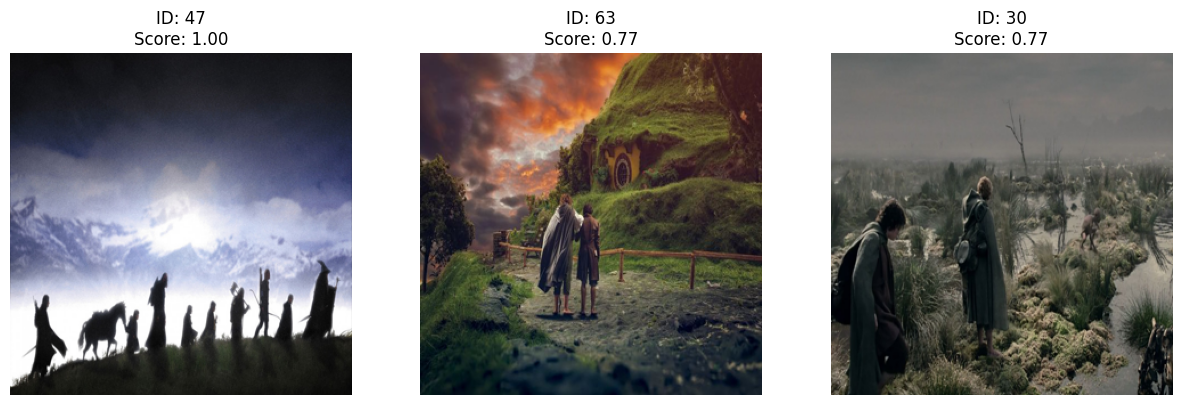

In [ ]:
# 0. For a random image
n = random.randint(0,len(list_valid_image_urls)-1)
print(f"Sample image with index {n} in {list_valid_image_urls[n]}")
# 1. Get the image from url
LOR_image_query = get_image(list_valid_image_urls[n])
# 2. Obtain embeddings (via CLIP) for the given image
LOR_query_embedding = get_single_image_embedding(LOR_image_query, processor, model, device).tolist()
# 3. Search on Vector DB index for similar images to "LOR_query_embedding"
LOR_results = my_index.query(LOR_query_embedding, top_k=3, include_metadata=True)
# 4. See the results
plot_top_matches_seaborn(LOR_results)

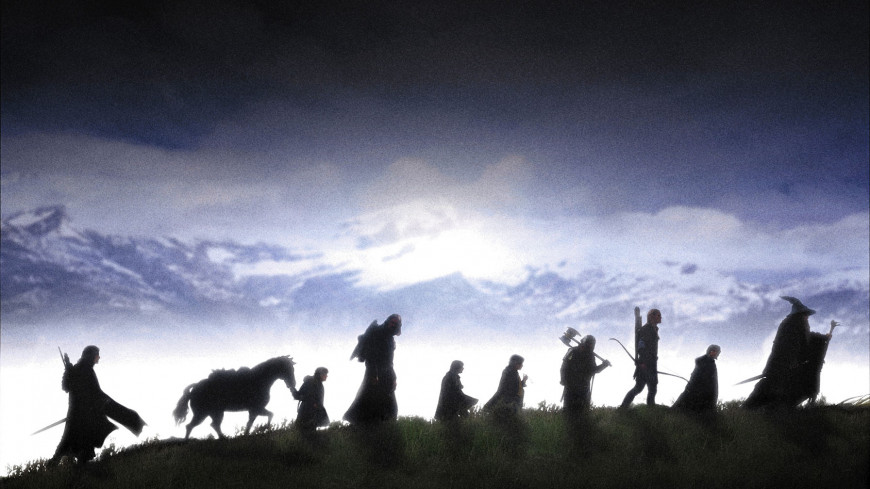

In [ ]:
LOR_image_query

In [ ]:
def create_dataset(list_image_urls, folder_name):
  os.makedirs(folder_name exist_ok=True)
  for i, image_url in enumerate(list_image_urls):
    img = Image.open(image_url)